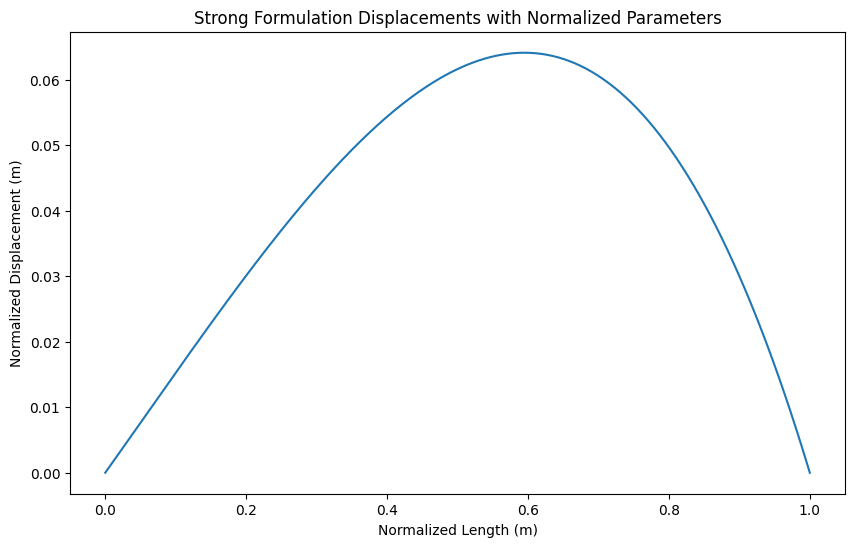

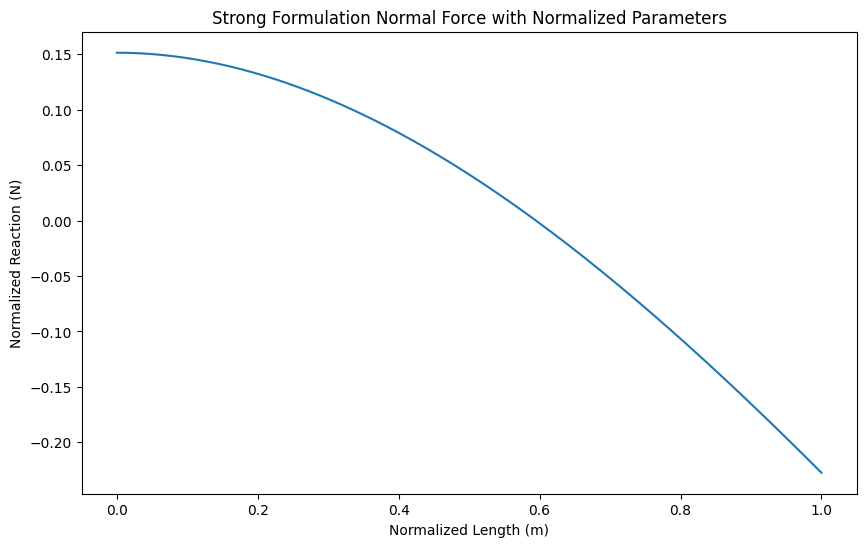

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We first relate the strong solution:
rho = 1
omega = 1
A0 = 1
A_L = (7/11) * A0
E = 1
L = 1

K_1 = (-(1/9) + (11/48) + (121/96) + (1331/384) * np.log((7/11))) / ((11/4) * np.log((7/11)))

K_2 = -3993/256

# strong formulation
xs = np.linspace(0, L, 250)
us = [-(1/9)*x**3 + (11/48)*x**2 + (121/96)*x + 1331/384*np.log(-4*x/11 + 1) + 3993/256 - K_1 * 11/4*np.log(1-4*x/11) + K_2 for x in xs]

plt.figure(figsize=(10,6))
plt.plot(xs, us)
plt.title('Strong Formulation Displacements with Normalized Parameters')
plt.xlabel('Normalized Length (m)')
plt.ylabel('Normalized Displacement (m)')

def u(x):
  return -(1/9)*x**3 + (11/48)*x**2 + (121/96)*x + 1331/384*np.log(-4*x/11 + 1) + 3993/256 - K_1 * 11/4*np.log(1-4*x/11) + K_2

def normal(x):
  return -(x**2/2 - 4*x**3/33/L) + K_1

ns = [normal(x) for x in xs]
plt.figure(figsize=(10,6))
plt.plot(xs, ns)
plt.title('Strong Formulation Normal Force with Normalized Parameters')
plt.xlabel('Normalized Length (m)')
plt.ylabel('Normalized Reaction (N)')


# weak formulation
def A(x):
  return A0 * (1 - 4*x/11/L)

def f(x):
  return rho * A(x) * omega * omega * x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We now relate the psi shape functions

def psi_1(x_0, x_f, x):
  return (x_f - x) / (x_f - x_0)

def psi_2(x_0, x_f, x):
  return (x - x_0) / (x_f - x_0)

# This equation can be written as psi_1 * psi_2, but will be explicit in this case
def psi_3(x_0, x_f, x):
  return (-x*x + x*(x_0 + x_f) - x_0*x_f) / (x_f - x_0)**2

# Relating the derivatives of the shape functions

def d_psi_1(x_0, x_f, x):
  return - 1 / (x_f - x_0)

def d_psi_2(x_0, x_f, x):
  return 1 / (x_f - x_0)

def d_psi_3(x_0, x_f, x):
  return (-2*x + x_0 + x_f) / (x_f - x_0)**2


# Function to convert z values to x values

def z_to_x(x_0, x_f, z):
  return (x_f - x_0) / 2 * z + (x_0 + x_f) / 2


# Converting k_mn integrand to hat function
# NOTE: 3 point GL has NOT been performed, simply conversion to xi domain
def k_hat(x_0, x_f, z, m, n):
  x = z_to_x(x_0, x_f, z)

  d1_string = 'd_psi_'+str(m)+'(x_0, x_f, x)'
  d2_string = 'd_psi_'+str(n)+'(x_0, x_f, x)'
  d1 = eval(d1_string)
  d2 = eval(d2_string)

  return A(x) * E * d1 * d2 * (x_f - x_0) / 2

# Converting f_m integrand to hat function
# NOTE: 3 point GL has NOT been performed, simply conversion to xi domain
def f_hat(x_0, x_f, z, m, n):
  x = z_to_x(x_0, x_f, z)

  p_string = 'psi_'+str(m)+'(x_0, x_f, x)'
  p = eval(p_string)

  return f(x) * p * (x_f - x_0) / 2


# Function to expedite 3 point GL method
def three_pt_gl(func, x_0, x_f, m, n):
  pt1 = 5/9 * func(x_0, x_f, -np.sqrt(3/5), m, n)
  pt2 = 8/9 * func(x_0, x_f, 0, m, n)
  pt3 = 5/9 * func(x_0, x_f, np.sqrt(3/5), m, n)

  return pt1 + pt2 + pt3


# Function for k matrix for an interval
def k_mn_i(x_0, x_f, m, n):
  return three_pt_gl(k_hat, x_0, x_f, m, n)

# Function for f matrix for an interval
def f_m_i(x_0, x_f, m):
  return three_pt_gl(f_hat, x_0, x_f, m, -1)

# As of right now, we can find for any interval, the K and F matrices
# However, this is not useful for global assembly due to alpha term in matrix equation
# We can find using matrix condensation a more useful equation

# Function for the k_bar matrix using matrix condensation
def k_bar_mn_i(x_0, x_f, m, n):
  og = k_mn_i(x_0, x_f, m, n)

  new_num = k_mn_i(x_0, x_f, m, 3) * k_mn_i(x_0, x_f, 3, n)
  new_denom = k_mn_i(x_0, x_f, 3, 3)

  return og - new_num/new_denom

# Function for the f_bar matrix using matrix condensation
def f_bar_m_i(x_0, x_f, m):
  og = f_m_i(x_0, x_f, m)

  new_num = k_mn_i(x_0, x_f, m, 3) * f_m_i(x_0, x_f, 3)
  new_denom = k_mn_i(x_0, x_f, 3, 3)

  return og - new_num/new_denom


# Function for creating the global assembly of equations to solve for U_i
def global_assembly(num, choice=False):
  mesh = np.linspace(0, 1, num+1)

  left_coefs = np.zeros((num-1, num-1))

  right_coefs = np.zeros((num-1, 1))

  root_stuff_f = 0
  root_stuff_k = 0

  for i in range(0, num-1):
    x_iminus1 = mesh[i]
    x_i = mesh[i+1]
    x_iplus1 = mesh[i+2]

    for j in range(0, num-1):
      if i == j:
        left_coefs[i][j] = k_bar_mn_i(x_iminus1, x_i, 2, 2) + k_bar_mn_i(x_i, x_iplus1, 1, 1)

      elif j == i + 1:
        left_coefs[i][j] = k_bar_mn_i(x_i, x_iplus1, 1, 2)

      elif j == i - 1:
        left_coefs[i][j] = k_bar_mn_i(x_iminus1, x_i, 2, 1)

    right_coefs[i][0] = f_bar_m_i(x_iminus1, x_i, 2) + f_bar_m_i(x_i, x_iplus1, 1)

    # returning necessary values for the root reaction
    if i == 0 :
      root_stuff_f = f_bar_m_i(x_iminus1, x_i, 1)
      root_stuff_k = k_bar_mn_i(x_iminus1, x_i, 1, 2)

  U = np.linalg.inv(left_coefs) @ right_coefs
  pt1 = np.array([[0]])
  ptlast = np.array([[0]])
  tot_U = np.vstack((pt1, np.vstack((U, ptlast))))

  if choice:
    return mesh, tot_U.T[0], root_stuff_f, root_stuff_k

  return mesh, tot_U.T[0]


print('Exact midpoint solution is', u(0.5))



# With U_i found, we can substitute them into an expression for alpha to find its value

# Function to find alpha of an interval
def alpha_i(num, i):
  mesh, displace = global_assembly(num)
  x_0 = mesh[i-1]
  x_f = mesh[i]

  paren = f_m_i(x_0, x_f, 3) - k_mn_i(x_0, x_f, 3, 1) * displace[i-1] - k_mn_i(x_0, x_f, 3, 2) * displace[i]

  return paren / k_mn_i(x_0, x_f, 3, 3)

# Function to compute u(x)
def u_guess(num, i, x):
  mesh, displace = global_assembly(num)
  x_0 = mesh[i-1]
  x_f = mesh[i]

  guess = displace[i-1] * psi_1(x_0, x_f, x) + displace[i] * psi_2(x_0, x_f, x) + alpha_i(num, i) * psi_3(x_0, x_f, x)

  return guess

Exact midpoint solution is 0.06160207590701994


[0.         0.06159635 0.        ]
[0.         0.03701207 0.0616017  0.05611757 0.        ]
[0.         0.01903822 0.03701229 0.05190955 0.06160205 0.06382011
 0.05611791 0.03582799 0.        ]
[0.         0.00953026 0.01903823 0.02828164 0.0370123  0.04497555
 0.05190957 0.05754459 0.06160207 0.06379367 0.06382013 0.06136996
 0.05611793 0.04772335 0.035828   0.02005381 0.        ]
[0.         0.00475299 0.00953026 0.01430204 0.01903823 0.02370837
 0.02828164 0.03272682 0.0370123  0.04110604 0.04497555 0.04858788
 0.05190957 0.05490665 0.05754459 0.05978831 0.06160208 0.06294954
 0.06379368 0.06409671 0.06382013 0.06292461 0.06136996 0.05911508
 0.05611793 0.05233541 0.04772335 0.04223641 0.03582801 0.02845025
 0.02005381 0.01058788 0.        ]
[0.         0.00237161 0.00475299 0.00714044 0.00953026 0.01191871
 0.01430204 0.01667648 0.01903823 0.02138348 0.02370837 0.02600906
 0.02828164 0.03052221 0.03272682 0.03489151 0.0370123  0.03908516
 0.04110604 0.04307087 0.04497555 0.04681594

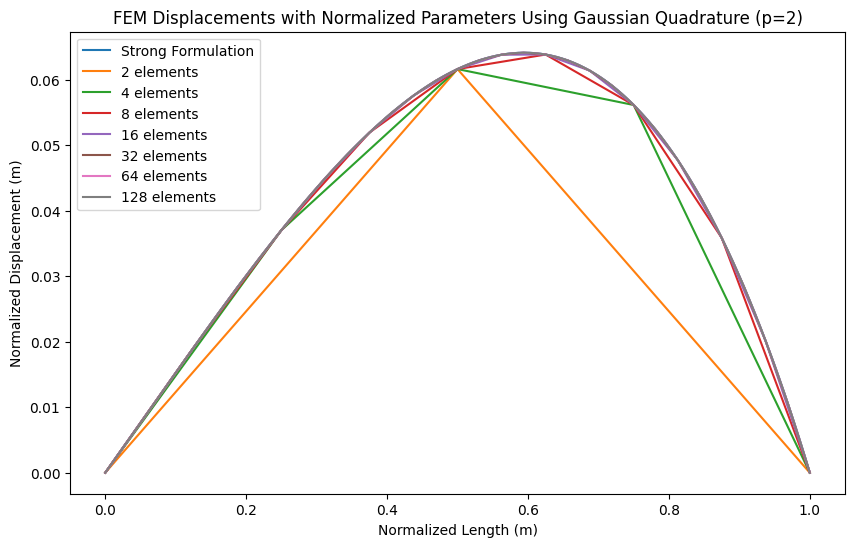

In [ ]:
# Plotting solutions ranging from n = 2 to 64:

exps = range(1, 8)
nums = [2**x for x in exps]

plt.figure(figsize=(10,6))
plt.plot(xs, us, label='Strong Formulation')

midpoints = []
for i in nums:
  mesh, displacements = global_assembly(i)
  print(displacements)
  plt.plot(mesh, displacements, label=str(i)+' elements')

  num = int((2**np.log2(i) + 1) / 2 - 0.5)
  midpoints.append(displacements[num])

print()
print(midpoints)
plt.title('FEM Displacements with Normalized Parameters Using Gaussian Quadrature (p=2)')
plt.xlabel('Normalized Length (m)')
plt.ylabel('Normalized Displacement (m)')
plt.legend(loc='upper left')
plt.show()


100%|██████████| 4/4 [04:05<00:00, 61.40s/it]


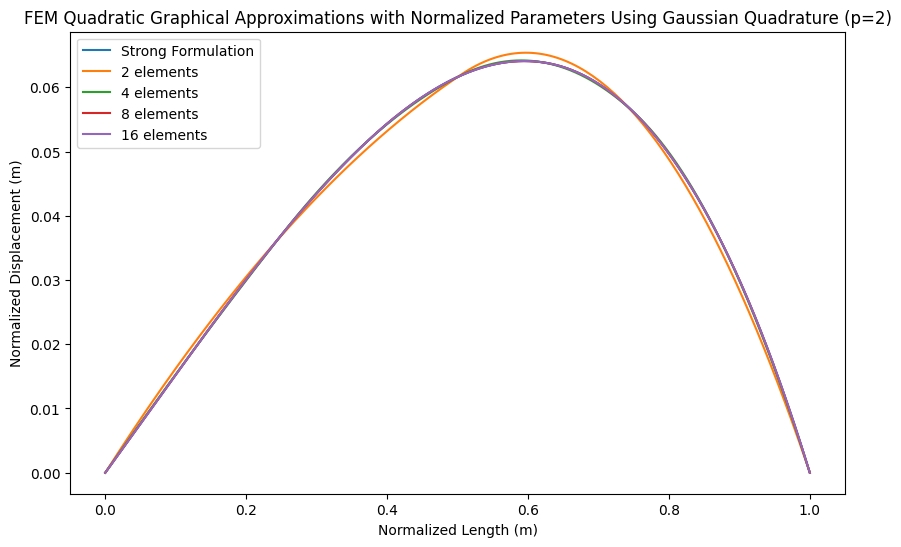

In [ ]:
# Another plot with quadratic splines

# Function to organize quadratic splines to approximate the strong formulation

from tqdm import tqdm

def fem_organizer(num):

  mesh = np.linspace(0, 1, num+1)
  sub_meshes = []
  splines = []

  for i in range(1, num+1):
    x_0 = mesh[i-1]
    x_f = mesh[i]

    sub_mesh = list(np.linspace(x_0, x_f, 100))
    sub_meshes.extend(sub_mesh)

    spline = [u_guess(num, i, x) for x in sub_mesh]
    splines.extend(spline)

  return sub_meshes, splines


exps = range(1, 5)
nums = [2**x for x in exps]

plt.figure(figsize=(10,6))
plt.plot(xs, us, label='Strong Formulation')

for i in tqdm(nums):
  subs, ys = fem_organizer(i)
  plt.plot(subs, ys, label=str(i)+' elements')


plt.title('FEM Quadratic Graphical Approximations with Normalized Parameters Using Gaussian Quadrature (p=2)')
plt.xlabel('Normalized Length (m)')
plt.ylabel('Normalized Displacement (m)')
plt.legend(loc='upper left')
plt.show()

[0.06159635053463506, 0.06160170089460994, 0.061602052174886894, 0.061602074419055304, 0.06160207581394801, 0.06160207590120085, 0.06160207590665816, 0.06160207590699846]
Rate of Midpoint Convergence:
-------------------------------------------

Rate of convergence from 2 to 4 is: 3.932359287303511
Rate of convergence from 4 to 8 is: 3.9820246575456055
Rate of convergence from 8 to 16 is: 3.9954296343469458
Rate of convergence from 16 to 32 is: 3.998850376764813
Rate of convergence from 32 to 64 is: 3.9994810144226243
Rate of convergence from 64 to 128 is: 4.007608369035671
Rate of convergence from 128 to 256 is: 4.0743239279794725


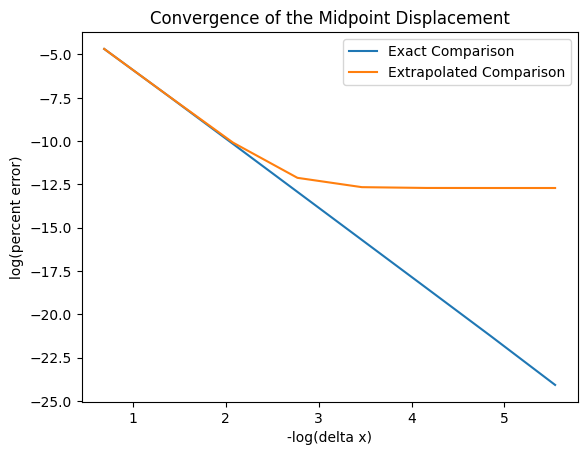

In [ ]:
# Now we analyze the rate of convergence of the midpoint of the FEM above
# The rate of convergence is compared both against the exact value and the extrapolated value
# Thus, we should have two lines shown on the plot

exact_midpoint = u(0.5)
print(midpoints)
midpoint_errors = [np.log(np.abs(exact_midpoint - x) / np.abs(exact_midpoint) * 100) for x in midpoints]
midpoint_abs_errors = [np.abs(exact_midpoint - x) for x in midpoints]

extrapolated_midpoint = ((midpoints[5])**2 - midpoints[4]*midpoints[6]) / (2 * midpoints[5] - midpoints[4] - midpoints[6])
mid_ex_errors = [np.log(np.abs(extrapolated_midpoint - x) / np.abs(extrapolated_midpoint) * 100) for x in midpoints]

delta_xs = [np.log((0.5)**i)*-1 for i in range(1, 9)]

plt.title('Convergence of the Midpoint Displacement')
plt.xlabel('-log(delta x)')
plt.ylabel('log(percent error)')
plt.plot(delta_xs, midpoint_errors, label='Exact Comparison')
plt.plot(delta_xs, mid_ex_errors, label='Extrapolated Comparison')
plt.legend(loc='upper right')


print('Rate of Midpoint Convergence:')
print('-------------------------------------------')
print()
# Considering the later values, particularly 2^4 subintervals and on
for i in range(0, len(midpoint_abs_errors) - 1):
  print('Rate of convergence from', 2**(i+1), 'to', 2**(i+2), 'is:', np.log2(midpoint_abs_errors[i]/midpoint_abs_errors[i+1]))

In [ ]:
# Now we analyze the rate of convergence of the root reaction of the FEM above
# The rate of convergence is compared both against the exact value and the extrapolated value
# Additionally, both the methods of direct differentiation and weak formulation are used
# Thus, we should have four lines shown on the plot


# finding the direct differentation method for root reaction calculations
def root_direct(num):
  mesh, data = global_assembly(num)
  return E * A(0) * (data[1] + alpha_i(num, 1)) / (mesh[1] - mesh[0])

# Exact root reaction
print('Exact Method of Root Reaction')
print('-----------------------------------------------')
print()
print(normal(0))
root_exact = normal(0)

print()


# we choose to analyze 4 to 8, 8 to 16, and 16 to 32

# root reaction by direct differentiation at 2 to 128
print('Direct Differentiation Method of Root Reaction:')
print('-----------------------------------------------')
print()
root_dd_lst = []
for i in range(1, 9):
  root_dd = root_direct(2**i)
  root_dd_lst.append(root_dd)
  print(2**i, 'elements give', root_dd)

print()

# root reaction by weak formulation at 2 to 1024
print('Weak Formulation Method of Root Reaction:')
print('-----------------------------------------')
print()
root_weak_lst = []
for j in range(1, 9):
  mesh, displacements, f_bar_1, k_bar_12 = global_assembly(2**j, True)
  root_weak = f_bar_1 - k_bar_12 * displacements[1]
  root_weak_lst.append(root_weak)
  print(2**j, 'elements give', root_weak)

Exact Method of Root Reaction
-----------------------------------------------

0.15139205516732435

Direct Differentiation Method of Root Reaction:
-----------------------------------------------

2 elements give 0.1721234309623431
4 elements give 0.1564745658327223
8 elements give 0.15265188431042073
16 elements give 0.15170575131649142
32 elements give 0.151470326576751
64 elements give 0.15141160423958452
128 elements give 0.15139694010608462
256 elements give 0.15139327611197506

Weak Formulation Method of Root Reaction:
-----------------------------------------

2 elements give 0.15135490187791442
4 elements give 0.15138967881125673
8 elements give 0.15139190573333214
16 elements give 0.15139204581317187
32 elements give 0.15139205458246166
64 elements give 0.15139205513076512
128 elements give 0.15139205516504303
256 elements give 0.1513920551671826


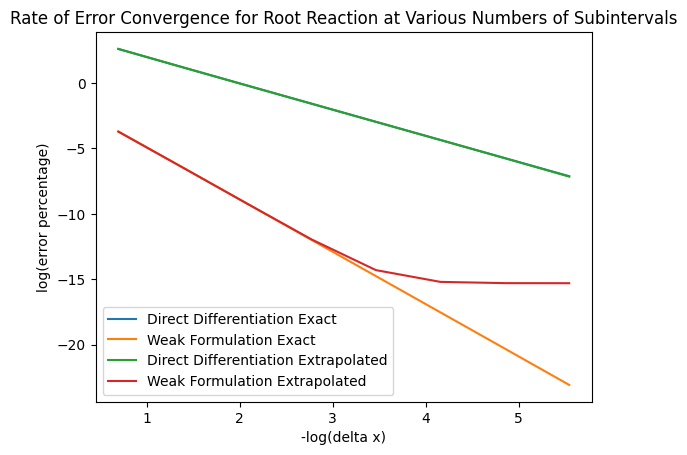

In [ ]:
root_dd_errors = [np.log(np.abs((root_exact - x)) / np.abs(root_exact) * 100) for x in root_dd_lst]

root_dd_extrap = ((root_dd_lst[4])**2 - root_dd_lst[3]*root_dd_lst[5]) / (2 * root_dd_lst[4] - root_dd_lst[3] - root_dd_lst[5])
root_dd_extrap_errors = [np.log(np.abs((root_dd_extrap - x)) / np.abs(root_dd_extrap) * 100) for x in root_dd_lst]

root_weak_errors = [np.log(np.abs((root_exact - x)) / np.abs(root_exact) * 100) for x in root_weak_lst]

root_weak_extrap = ((root_weak_lst[4])**2 - root_weak_lst[3]*root_weak_lst[5]) / (2 * root_weak_lst[4] - root_weak_lst[3] - root_weak_lst[5])
root_weak_extrap_errors = [np.log(np.abs((root_weak_extrap - x)) / np.abs(root_weak_extrap) * 100) for x in root_weak_lst]

delta_xs = [np.log((0.5)**i)*-1 for i in range(1, 9)]

plt.plot(delta_xs, root_dd_errors, label='Direct Differentiation Exact')
plt.plot(delta_xs, root_weak_errors, label='Weak Formulation Exact')
plt.plot(delta_xs, root_dd_extrap_errors, label='Direct Differentiation Extrapolated')
plt.plot(delta_xs, root_weak_extrap_errors, label='Weak Formulation Extrapolated')
plt.xlabel('-log(delta x)')
plt.ylabel('log(error percentage)')
plt.title('Rate of Error Convergence for Root Reaction at Various Numbers of Subintervals')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# Actual calculation of the rates of convergence
# Direct Differentiation method

root_dd_absolute_errors = [np.abs(x - root_exact) for x in root_dd_lst]
root_weak_absolute_errors = [np.abs(x - root_exact) for x in root_weak_lst]


print('Direct Differentiation Rate of Convergence:')
print('-------------------------------------------')
print()
# Considering the later values, particularly 2^4 subintervals and on
for i in range(3, len(root_dd_absolute_errors) - 1):
  print('Rate of convergence from', 2**(i+1), 'to', 2**(i+2), 'is:', np.log2(root_dd_absolute_errors[i]/root_dd_absolute_errors[i+1]))

print()

print('Weak Formulation Rate of Convergence:')
print('-------------------------------------')
print()
# Considering the same values as in the DD method, 2^4 subintervals and on
for j in range(3, len(root_weak_absolute_errors) - 1):
  print('Rate of convergence from', 2**(j+1), 'to', 2**(j+2), 'is:', np.log2(root_weak_absolute_errors[j]/root_weak_absolute_errors[j+1]))

Direct Differentiation Rate of Convergence:
-------------------------------------------

Rate of convergence from 16 to 32 is: 2.0028104905197313
Rate of convergence from 32 to 64 is: 2.001385280382506
Rate of convergence from 64 to 128 is: 2.0006877620508785
Rate of convergence from 128 to 256 is: 2.0003426761762713
Rate of convergence from 256 to 512 is: 2.000170999265864
Rate of convergence from 512 to 1024 is: 2.0000871881627873

Weak Formulation Rate of Convergence:
-------------------------------------

Rate of convergence from 16 to 32 is: 3.99943709214362
Rate of convergence from 32 to 64 is: 3.9997904427692736
Rate of convergence from 64 to 128 is: 4.002298646182029
Rate of convergence from 128 to 256 is: 4.008467567270622
Rate of convergence from 256 to 512 is: 8.617820625571325
Rate of convergence from 512 to 1024 is: -7.972427558292701


In [ ]:
for i in range(1, 4):
  alphas = []
  for j in range(1, 2**i+1):
    alphas.append(alpha_i(2**i, j))
  print(alphas)


[0.024465364946536484, 0.10066829381682947]
[0.002106567927090969, 0.01038344066507789, 0.01980789006883864, 0.031032837981623505]
[4.326076098089112e-05, 0.0010240701468464954, 0.0020569211267865003, 0.0031533698685825627, 0.004328368040391976, 0.00560153450104104, 0.006999019493546123, 0.008556299238858025]
